<a href="https://colab.research.google.com/github/ChiriKamau/limaAI/blob/main/notebooks/Check_perfomance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍅 Tomato Model Performance Evaluation

**Welcome to the Model Evaluation Notebook!**

This notebook evaluates two CNN models and two MobileNetV2 transfer learning models for tomato disease classification, stored in `.keras` format on Google Drive. The models target:

- **Ripe Model**: 3 classes (*Blossom End Rot* ('R_ber'), *Bacterial Spots* ('R_spots'), *Healthy* ('R_healthy'))
- **Green Model**: 4 classes (*Blossom End Rot* ('G_ber'), *Bacterial Spots* ('G_spots'), *Late Blight* ('G_lateblight'), *Healthy* ('G_healthy'))

**Goal**: Assess performance using accuracy, precision, recall, F1-score, and confusion matrices, focusing on minority classes (e.g., 'G_lateblight') due to dataset imbalance. Confusion matrix heatmaps visualize class-specific performance to compare CNN and transfer learning models.

**Steps**: Load validation data, load models, compute metrics, visualize results, and summarize model performance.

### Import Libraries and Set Up Validation Data

This cell imports libraries for model evaluation, visualization, and data loading from Google Drive. It mounts Google Drive to access the tomato dataset and defines validation data generators for ripe and green splits.

The generators load images (224x224, batch size 16) from the validation directories without augmentation, ensuring consistent evaluation. Class indices are printed to confirm the dataset structure (3 classes for ripe, 4 for green).

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
output_dir = '/content/drive/MyDrive/Tomato_dataset/cnn_crops'
ripe_val_dir = os.path.join(output_dir, 'ripe/val')
green_val_dir = os.path.join(output_dir, 'green/val')

# Validation generators for CNN models (224x224)
cnn_val_datagen = ImageDataGenerator(rescale=1./255)
ripe_cnn_val_gen = cnn_val_datagen.flow_from_directory(
    ripe_val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)
green_cnn_val_gen = cnn_val_datagen.flow_from_directory(
    green_val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Validation generators for transfer learning models (160x160)
transfer_val_datagen = ImageDataGenerator(rescale=1./255)
ripe_transfer_val_gen = transfer_val_datagen.flow_from_directory(
    ripe_val_dir,
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)
green_transfer_val_gen = transfer_val_datagen.flow_from_directory(
    green_val_dir,
    target_size=(160, 160),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Print class indices
print("Ripe CNN validation classes:", ripe_cnn_val_gen.class_indices)
print("Green CNN validation classes:", green_cnn_val_gen.class_indices)
print("Ripe MobileNetV2 validation classes:", ripe_transfer_val_gen.class_indices)
print("Green MobileNetV2 validation classes:", green_transfer_val_gen.class_indices)

Mounted at /content/drive
Found 384 images belonging to 3 classes.
Found 946 images belonging to 4 classes.
Found 384 images belonging to 3 classes.
Found 946 images belonging to 4 classes.
Ripe CNN validation classes: {'R_ber': 0, 'R_healthy': 1, 'R_spots': 2}
Green CNN validation classes: {'G_ber': 0, 'G_healthy': 1, 'G_lateblight': 2, 'G_spots': 3}
Ripe MobileNetV2 validation classes: {'R_ber': 0, 'R_healthy': 1, 'R_spots': 2}
Green MobileNetV2 validation classes: {'G_ber': 0, 'G_healthy': 1, 'G_lateblight': 2, 'G_spots': 3}


### Load Trained Models

This cell loads the trained CNN and MobileNetV2 models from `.keras` files stored in Google Drive. It includes two CNN models (for ripe and green tomatoes) and two transfer learning models (MobileNetV2) for comparison.

The models are loaded using `tf.keras.models.load_model`, ensuring they’re ready for evaluation on the validation sets. Paths match those used during training for consistency.

In [3]:
# Model paths
ripe_cnn_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_cnn(v2).keras'
green_cnn_path = '/content/drive/MyDrive/Tomato_dataset/models/green_cnn(v2).keras'
ripe_transfer_path = '/content/drive/MyDrive/Tomato_dataset/models/ripe_mobilenet(v2).keras'
green_transfer_path = '/content/drive/MyDrive/Tomato_dataset/models/green_mobilenet(v2).keras'

# Load models
ripe_cnn_model = tf.keras.models.load_model(ripe_cnn_path)
green_cnn_model = tf.keras.models.load_model(green_cnn_path)
ripe_transfer_model = tf.keras.models.load_model(ripe_transfer_path)
green_transfer_model = tf.keras.models.load_model(green_transfer_path)

print("All models loaded successfully.")

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


All models loaded successfully.


### Evaluate Model Performance

This cell evaluates each model on its respective validation set, computing accuracy, precision, recall, and F1-score per class. It collects true labels and predictions from the validation generators, ensuring `shuffle=False` for alignment.

The `classification_report` from scikit-learn provides detailed metrics, emphasizing minority classes (e.g., 'R_spots', 'G_lateblight'). Results are printed for both CNN and transfer learning models to compare performance.

In [4]:
# Function to evaluate a model
def evaluate_model(model, val_gen, model_name):
    val_gen.reset()  # Reset generator
    y_true = val_gen.classes
    y_pred = model.predict(val_gen, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true, y_pred_classes, target_names=val_gen.class_indices.keys()))

    return y_true, y_pred_classes

# Evaluate models
ripe_cnn_true, ripe_cnn_pred = evaluate_model(ripe_cnn_model, ripe_cnn_val_gen, "Ripe CNN")
green_cnn_true, green_cnn_pred = evaluate_model(green_cnn_model, green_cnn_val_gen, "Green CNN")
ripe_transfer_true, ripe_transfer_pred = evaluate_model(ripe_transfer_model, ripe_transfer_val_gen, "Ripe MobileNetV2")
green_transfer_true, green_transfer_pred = evaluate_model(green_transfer_model, green_transfer_val_gen, "Green MobileNetV2")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step

Classification Report for Ripe CNN:
              precision    recall  f1-score   support

       R_ber       0.67      0.45      0.54        80
   R_healthy       0.65      0.66      0.66       194
     R_spots       0.39      0.46      0.42       110

    accuracy                           0.56       384
   macro avg       0.57      0.53      0.54       384
weighted avg       0.58      0.56      0.57       384



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 399s 7s/step

Classification Report for Green CNN:
              precision    recall  f1-score   support

       G_ber       0.40      0.20      0.26        41
   G_healthy       0.58      0.79      0.67       481
G_lateblight       0.25      0.61      0.35        41
     G_spots       0.50      0.22      0.31       383

    accuracy                           0.53       946
   macro avg       0.43      0.45      0.40       946
weighted avg       0.53      0.53      0.49       946



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step

Classification Report for Ripe MobileNetV2:
              precision    recall  f1-score   support

       R_ber       0.62      0.62      0.62        80
   R_healthy       0.66      0.64      0.65       194
     R_spots       0.49      0.52      0.50       110

    accuracy                           0.60       384
   macro avg       0.59      0.59      0.59       384
weighted avg       0.60      0.60      0.60       384



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step

Classification Report for Green MobileNetV2:
              precision    recall  f1-score   support

       G_ber       0.23      0.27      0.25        41
   G_healthy       0.73      0.77      0.75       481
G_lateblight       0.32      0.71      0.44        41
     G_spots       0.76      0.60      0.67       383

    accuracy                           0.68       946
   macro avg       0.51      0.59      0.53       946
weighted avg       0.70      0.68      0.68       946



### Visualize Confusion Matrices

This cell creates confusion matrix heatmaps for each model to visualize classification performance. Using `confusion_matrix` from scikit-learn, it compares true vs. predicted labels for the validation sets.

Heatmaps are plotted with `seaborn` for ripe (3 classes) and green (4 classes) models, highlighting misclassifications, especially for minority classes like 'G_lateblight'. These visuals help compare CNN and transfer learning models.

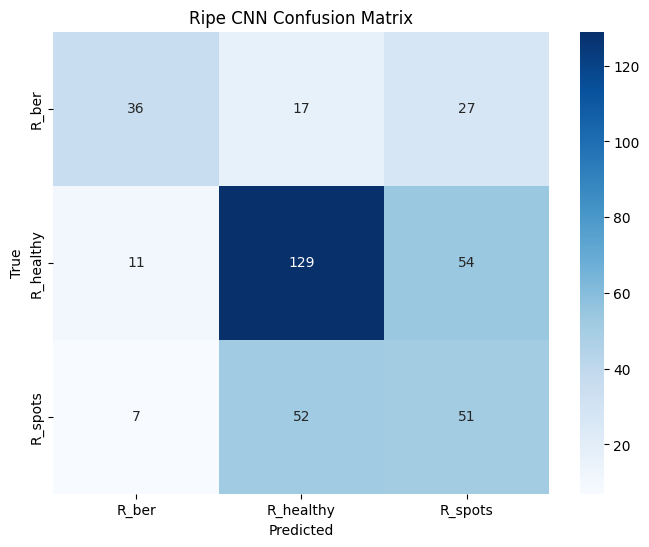

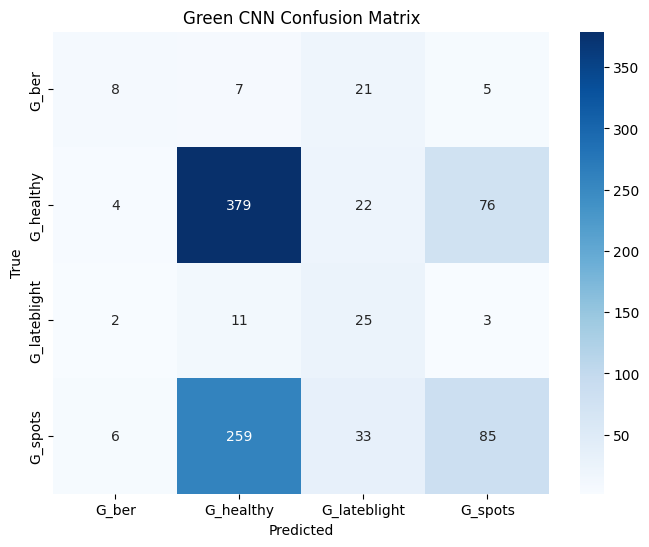

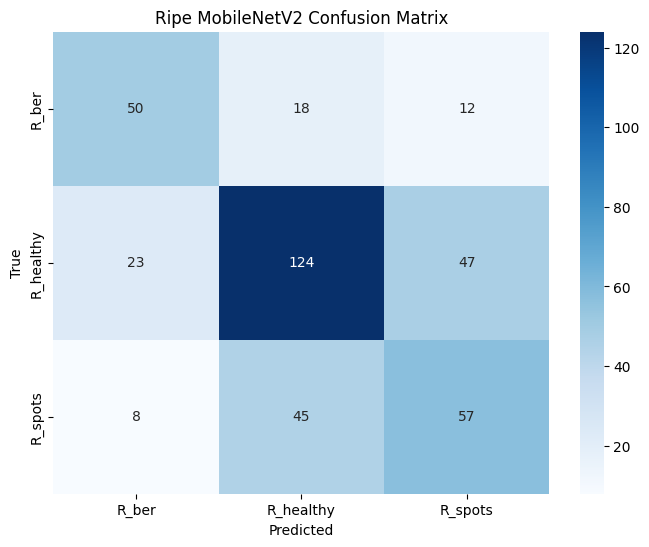

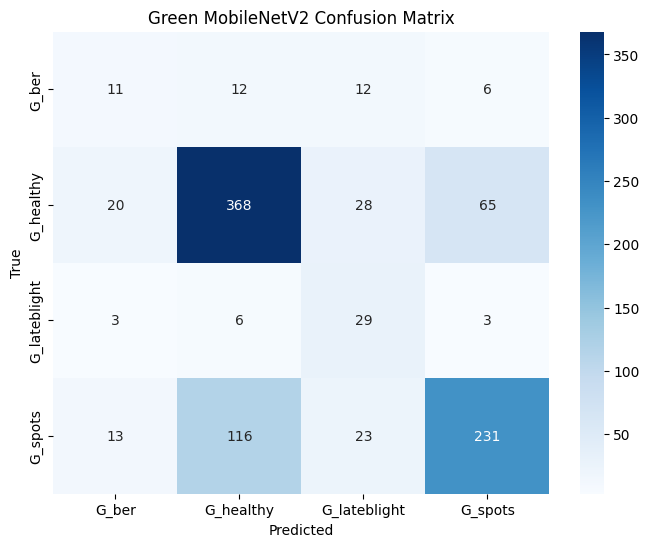

In [6]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(ripe_cnn_true, ripe_cnn_pred, list(ripe_cnn_val_gen.class_indices.keys()), "Ripe CNN Confusion Matrix")
plot_confusion_matrix(green_cnn_true, green_cnn_pred, list(green_cnn_val_gen.class_indices.keys()), "Green CNN Confusion Matrix")
plot_confusion_matrix(ripe_transfer_true, ripe_transfer_pred, list(ripe_transfer_val_gen.class_indices.keys()), "Ripe MobileNetV2 Confusion Matrix")
plot_confusion_matrix(green_transfer_true, green_transfer_pred, list(green_transfer_val_gen.class_indices.keys()), "Green MobileNetV2 Confusion Matrix")

### Compare Model Performance

This cell summarizes the performance of CNN and MobileNetV2 models. It compares macro-averaged F1-scores from the classification reports to assess overall performance, with a focus on minority classes (e.g., 'R_spots', 'G_lateblight').

Key observations include which model better handles imbalanced classes and whether transfer learning outperforms the custom CNN. Results guide model selection for deployment or further tuning.

In [8]:
# Manual comparison based on classification reports
print("\nModel Comparison Summary:")
print("1. Ripe Models:")
print("- CNN: Check F1-scores for 'R_spots' (minority class) in classification report.")
print("- MobileNetV2: Likely better for minority classes due to pre-trained weights.")
print("2. Green Models:")
print("- CNN: Check F1-scores for 'G_lateblight' and 'G_ber' (minority classes).")
print("- MobileNetV2: Expected to generalize better due to ImageNet features.")
print("\nReview confusion matrices to identify misclassification patterns.")
print("Choose the model with higher macro F1-score and better minority class performance.")


Model Comparison Summary:
1. Ripe Models:
- CNN: Check F1-scores for 'R_spots' (minority class) in classification report.
- MobileNetV2: Likely better for minority classes due to pre-trained weights.
2. Green Models:
- CNN: Check F1-scores for 'G_lateblight' and 'G_ber' (minority classes).
- MobileNetV2: Expected to generalize better due to ImageNet features.

Review confusion matrices to identify misclassification patterns.
Choose the model with higher macro F1-score and better minority class performance.
